# Repurposing Data Sources

_All language is but a poor translation._

Franz Kafka 

Sometimes data lives in formats that take extra work to ingest.  For common and explicitly data-oriented formats, common libraries already have readers built into them.  Data frame libraries, for example, read a huge number of different file types.  At worst, slightly less common formats have their own more specialized libraries that provide a relatively straightforward path between the original format and the general purpose data processing library you wish to use.

A greater difficulty often arises because a given format is not *per se* a data format, but exists for a different purpose.  Nonetheless, often there is data somehow embedded or encoded in the format that we would like to utilize.  

For example, web pages are generally designed for human readers and often rendered by web browsers with "quirks modes" that deal with not-quite-HTML, as is often needed.  Portable Document Format (PDF) documents are similar in having intended human readers in mind, and yet also often containing tabular or other data that we would like to process as data scientists. 

In both cases, we would rather have the data itself in some separate, easily ingestible, format; but reality does not always live up to our hopes.  Image formats likewise are intended for presentation of pictures to humans; but we sometimes wish to characterize or analyze collections of images in some data science or machine learning manner.

Still other formats are indeed intended as data formats, but they are unusual enough that common readers for the formats will not be available.  Generally, custom text formats are manageable, especially if you have some documentation of what the rules of the format are.  Custom binary formats are usually more work, but possible to decode if the need is sufficiently pressing and other encodings do not exist.

In [1]:
from src.setup import *
%matplotlib inline

## Web Scraping

* HTML tables
* Non-tabular data
* Command-line scraping

A great deal of interesting data lives on web pages, and often, unfortunately, we do not have access to the same data in more structured data formats.  In the best cases, the data we are interested in at least lives within HTML tables inside of a web page; however, even where tables are defined, often the content of the cells has more than only the numeric or categorical values of interest to us.  For example, a given cell might contain commentary on the data point or a footnote providing a source for the information.  At other times, of course, the data we are interested in is not in HTML tables at all, but structured in some other manner across a web page.

The examples I'll show will use the Python library **BeautifulSoup** to parse web pages.  Within Python, **Scrapy** is another popular library.  For the R language, **rvest** is often useful.  In Ruby, **Nokogiri** is similar to Python's BeautifulSoup. **Colly** is a Golang approximately equivalent library. **Scraper** is Rust's answer.  And so on for other programming languages.

BeautifulSoup is friendly and is remarkably well able to handle malformed HTML.  In the real world, what gets called "HTML" is often only loosely conformant to any actual format standards, and hence web browsers, for example, are quite sophisticated (and complicated) in providing reasonable rendering of only vaguely structured tag soups.

## HTML Tables

<img src="img/Flu2009-infobox.png" alt="2009 Flu Infobox" width="40%"/>

Let's look at some data from Wikipedia to illustrate web scraping.  While there are surely other sources for similar data that we could locate, we will collect our data from the Wikipedia article on the 2009 flu pandemic.  Some data genuinely only readily exists on web pages.

In [2]:
url_flu_2009 = "https://te.wikipedia.org/wiki/%E0%B0%AE%E0%B1%82%E0%B0%B8:2009_flu_pandemic_data"

## Retrieve the Web Page

In [3]:
import requests
resp = requests.get(url_flu_2009)
resp.status_code

200

Constructing a script for web scraping, in practice, inevitably involves a some trial-and-error.  We generally need to eyeball the filtered and indexed elements, and refine this selection through repetition.  

In [4]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(resp.content)
tables = soup.findAll("table")
print(f"Found {len(tables)} tables")
for i, table in enumerate(tables):
    print(f"Table {i}: {' '.join(table["class"])}")

Found 2 tables
Table 0: box-Update plainlinks ombox ombox-content ambox-Update
Table 1: navbox vertical-navbox


In this case, I have already looked at the HTML source of Wikipedia pages, and I know that the style of table used for the mortality data is a `vertical-navbox`.  We can select it for further processing.

In [5]:
mortality = tables[1]
for tr in mortality.find_all("tr"):
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in tr.find_all("td")]
    print(row)        

[]
['Area', 'Confirmeddeaths']
['Worldwide (total)', '14,286']
['European Union and EFTA', '2,290']
['Other European countriesand Central Asia', '457']
['Mediterranean and Middle East', '1,450']
['Africa', '116']
['North America', '3,642']
['Central America and Caribbean', '237']
['South America', '3,190']
['Northeast Asia and South Asia', '2,294']
['Southeast Asia', '393']
['Australia and Pacific', '217']
['Source: ECDC – January 18, 2010[1]']
['Further information: Cases and deaths by country']
['Note: The ratio of confirmed deaths to total deaths due to the pandemicis unknown. For more information, see "Data reporting and accuracy".']
['vte']


We've made progress here.  But there also remain some problems.  

The first row and last few rows are citational and footnote information that we do not need for the current purpose.  We can also see that the string for "Other European countries and Central Asia" lacks an internal space because an HTML `<br/>` tag had occurred where we want a single string.  

We would also like to convert the string version of numbers to integers.

In [6]:
rows = []
for tr in mortality.find_all("tr")[2:13]:
    td = tr.find_all('td')
    region = td[0].text.strip().replace("sand", "s and")
    count = int(td[1].text.replace(",", ""))
    rows.append([region, count])

The shown code is brief, but I needed to experiment and eyeball the data a fair amount to arrive at it.  The list-of-lists we created can easily put into a DataFrame or other structure for analytic purposes.

In [7]:
pl.DataFrame(rows, orient="row", schema={
    "Region": pl.String, "Deaths": pl.Int32
}).style.fmt_integer(columns="Deaths")

Region,Deaths
Worldwide (total),"14,286"
European Union and EFTA,"2,290"
Other European countries and Central Asia,457
Mediterranean and Middle East,"1,450"
Africa,116
North America,"3,642"
Central America and Caribbean,237
South America,"3,190"
Northeast Asia and South Asia,"2,294"
Southeast Asia,393


Obviously this is a small example that could easily be typed in manually.  The general techniques shown might be applied to a much larger table.  More significantly, they might also be used to scrape a table on a web page that is updated frequently.  2009 is strictly historical, but other data is updated every day, or even every minute, and a few lines like the ones shown could pull down current data each time it needs to be processed.

## Non-Tabular Data

<img src="img/HTTP-status-codes.png" alt="HTTP status codes" width="75%"/>

For an example a non-tabular web page, we will again use Wikipedia as well.  In a slightly self-referential way, we will look at the article that lists HTTP status codes in a term/definition layout.  A portion of that page renders in my browser as shown.

Numerous other codes are listed in the articles that are not in the screenshot.  Moreover, there are section divisions and other descriptive elements or images throughout the page.  Fortunately, Wikipedia tends to be very regular and predictable in its use of markup.

In [8]:
url_http = ("https://en.wikipedia.org/w/index.php?"
            "title=List_of_HTTP_status_codes&oldid=947767948")

The first thing we need to do is actually retrieve the HTML content.

In [9]:
import requests
resp = requests.get(url_http)
print(resp.status_code)
pprint(resp.content[98100:98800], width=55)

200
(b'418"></span><a href="/wiki/HTTP_418" class="mw-r'
 b'edirect" title="HTTP 418">418 I\'m a teapot</a> ('
 b'RFC 2324, RFC 7168)</dt>\n<dd>This code was defin'
 b'ed in 1998 as one of the traditional <a href="/w'
 b'iki/Internet_Engineering_Task_Force" title="Inte'
 b'rnet Engineering Task Force">IETF</a> <a href="/'
 b'wiki/April_Fools%27_Day_RFC" class="mw-redirect"'
 b' title="April Fools&#39; Day RFC">April Fools\' j'
 b'okes</a>, in RFC 2324, <i><a href="/wiki/Hyper_T'
 b'ext_Coffee_Pot_Control_Protocol" title="Hyper Te'
 b'xt Coffee Pot Control Protocol">Hyper Text Coffe'
 b'e Pot Control Protocol</a></i>, and is not expec'
 b'ted to be implemented by actual HTTP servers.  T'
 b'he RFC specifies this code should be returned by'
 b' teapots requested to brew c')


The raw HTML we retrieved is not especially easy to work with.  Even apart from the fact it is compacted to remove extra whitespace, the general structure is a "tag soup" with various things nested in various places. Basic string methods or regular expressions do not help us very much in identifying the parts we are interested in.

In [10]:
class More: pass
more = More()
more.text = "..."

In [11]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(resp.content)

codes = soup.find_all('dt')
for code in codes[:5] + [more] + codes[-5:]:
    print(code.text)

100 Continue
101 Switching Protocols
102 Processing (WebDAV; RFC 2518)
103 Early Hints (RFC 8297)
200 OK
...
524 A Timeout Occurred
525 SSL Handshake Failed
526 Invalid SSL Certificate
527 Railgun Error
530


This is handled much more easily with BeautifulSoup.  As we've seen already, doing so first creates a "soup" object from the raw HTML, then using methods of that soup to pick out the elements we care about for our data set. 

We notice that the status codes themselves are each contained within an HTML &lt;dt&gt; element.  The first and last few of the elements identified by this tag are shown.

Everything without the `codes` variable is a status code. However, I only know that from manual inspection of all of them, albeiteyeballing fewer than 100 items is not difficult; doing so with a million would be infeasible).  

If we look back at the original web page, we can see that the 530 status code isn't captured because the page formatting is inconsistent.

In [12]:
def find_dds_after(node):
    dds = []
    sib = node.next_sibling
    while True:     # Loop until a break
        # Last sibling within page section
        if sib is None:
            break
        # Text nodes have no element name
        elif not sib.name: 
            sib = sib.next_sibling
            continue
        # A definition node
        if sib.name == 'dd':
            dds.append(sib)
            sib = sib.next_sibling
        # Finished <dd> the definition nodes
        else:
            break
    return dds

In the BeautifulSoup API, the empty space between elements is a node of plain text that contains exactly the characters (including whitespace) inside that span.  It is tempting to use the API called `node.find_next_siblings()` in this task.  

That method will fetch too much, however, including all subsequent &lt;dt&gt; elements after the current one.  Instead, we can use the property `.next_sibling` to get each one, and stop when needed.

The custom function I wrote is straightforward, but special to this purpose.  Perhaps it is extensible to similar definition lists one finds in other HTML documents.  BeautifulSoup provides numerous useful APIs, but they are building blocks for constructing custom extractors rather than foreseeing every possible structure in an HTML document. To understand it, let us look at a couple of the status codes.

In [13]:
for code in codes[23:26]:
    print(code.text)
    for dd in find_dds_after(code):
        print("  ", dd.text[:40], "...")

400 Bad Request
   The server cannot or will not process th ...
401 Unauthorized (RFC 7235)
   Similar to 403 Forbidden, but specifical ...
   Note: Some sites incorrectly issue HTTP  ...
402 Payment Required
   Reserved for future use. The original in ...


The HTTP 401 response contains two separate definition blocks. Let's apply the function across all the HTTP code numbers.  What is returned is a list of definition blocks; for our purpose we will join the text of each of these with a newline.

In [14]:
data = []
for code in codes:
    # All codes are 3 character numbers
    number = code.text[:3]
    # parenthetical is not part of status
    text, note = code.text[4:], ""
    if " (" in text:
        text, note = text.split(" (")
        note = note.rstrip(")")
    # Compose description from list of strings
    description = "\n".join(t.text for t in find_dds_after(code))
    data.append([int(number), text, note, description])

From the Python list of lists, we can create a DataFrame for further work on the data set.

In [15]:
(pd.DataFrame(
    data, columns=["Code", "Text", "Note", "Description"])
    .set_index('Code')
    .sort_index()
    .head(6))

,Text,Note,Description
Code,,,
100,Continue,,The server has received the request headers an...
101,Switching Protocols,,The requester has asked the server to switch p...
102,Processing,WebDAV; RFC 2518,A WebDAV request may contain many sub-requests...
103,Early Hints,RFC 8297,Used to return some response headers before fi...
103,Checkpoint,,Used in the resumable requests proposal to res...
200,OK,,Standard response for successful HTTP requests...


The two HTML examples we looked at are not general to all the web pages you may wish to scrape data from.  Organization into tables and into definition lists are certainly two common uses of HTML to represent data, but many other conventions might be used. 

Particular domain specific—or likely page specific—`class` and `id` attributes on elements is also a common way to mark the structural role of different data elements.  Be prepared to try many variations on your web scraping code before you get it right.  Generally, your iteration will be a narrowing process; each stage *needs to* include the information desired, it becomes a process of removing the parts you do not want through refinement.

## Command-Line Scraping

In [16]:
%%bash
base='https://en.wikipedia.org/w/index.php?title='
url="$base"'List_of_HTTP_status_codes&oldid=947767948'
lynx -width 66 -dump $url | sed -n '431,437p'

   308 Permanent Redirect (RFC 7538)
          The request and all future requests should be
          repeated using another URI. 307 and 308 parallel
          the behaviors of 302 and 301, but do not allow the
          HTTP method to change. So, for example, submitting
          a form to a permanently redirected resource may
          continue smoothly.^[201][29]


Text is often much easier to parse than is structured and nested HTML. "Flat is better than nested" according to the _Zen of Python_. 

The web browsers `lynx` and `links` provide a quick way to move the *content* you care about into plain text, which is relatively easy to parse.  Often looking for patterns of intentation, vertical space, searching for particular keywords, or similar text processing, will get the data you need more quickly than the trial-and-error of parsing libraries like BeautifulSoup.

These text-mode web browsers both have a `-dump` switch that outputs non-interactive text to STDOUT.  Each of them have a variety of other switches that can tweak the rendering of the text.  

The output from these two tools is similar, but the rest of your scripting will need to pay attention to the minor differences.  Each of these browsers will do a very good job of dumping 90% of web pages as text that is easy to process.  Of the problem 10%, often one or the other tool will produce something reasonable to parse.  In certain cases, one of these browsers may produce useful results and the other will not.  Fortunately, it is easy simply to try both for a given task or site.

In [17]:
%%bash
base='https://en.wikipedia.org/w/index.php?title='
url="$base"'List_of_HTTP_status_codes&oldid=947767948'
links -width 66 -dump $url | sed -n '394,400p'

   308 Permanent Redirect (RFC 7538)
           The request and all future requests should be
           repeated using another URI. 307 and 308 parallel the
           behaviors of 302 and 301, but do not allow the HTTP
           method to change. So, for example, submitting a form
           to a permanently redirected resource may continue
           smoothly.^[29]


Here is the `links` version of the rendering.

Obviously, I experimented, in both cases, to find the exact line ranges of output that correspond.  You can see that only incidental formatting differences exist in this friendly HTML page.

The only differences in the rendering is one space difference in indentation of the definition element and some difference in the formatting of footnote links in the text.

## How to Parse HTTP Status Code Descriptions

* Look for a line that starts with 3 spaces followed by a 3 digit number;
* Accumulate all non-blank lines following that, stop at blank line;
* Strip the footnote/link markers from the texts;
* Split the code number and text in the same manner as in the previous example.

Obviously, we *could* accomplish extraction of these status codes with BeautifulSoup or other libraries.  But tools already exist that do a lot of special casing and simplification for us.

The few steps mentioned in bullets are relatively general for any web page that utilizes definition lists.  You can work out the exact code yourself, but it should not take more than 10 lines in a high-level language such as Python.

## Portable Document Format

* Identifying tabular regions
* Extracting plain text

There are a great many commercial tools to extract data which has become hidden away in PDF files. Unfortunately, many organizations—government, corporate, and others—issue reports in PDF format but do not provide data formats more easily accessible to computer analysis and abstraction.  This is common enough to have provided impetus for a cottage industry of tools for semi-automatically extracting data back out of these reports. 

I recommend using open source tools for extraction of data from PDFs.  One of these it the command-line tool `pdftotext` which is part of the **Xpdf** and the derived **Poppler** software suites.  The second is a Java tool called **tabula-java**.  Tabula-java is in turn the underlying engine for the GUI tool **Tabula**, and also has language bindings for Ruby (**tabula-extractor**), Python (**tabula-py**), R (**tabulizer**), and Node.js (**tabula-js**). 

There are two main elements that are likely to interest us in a PDF file.  An obvious one is tables of data which are often embedded in PDFs.  Otherwise, a PDF can often simply be treated as a custom text format. Various kinds of lists, bullets, captions, or simply paragraph text, might have data of interest to us.

<img src="img/preface-1.png" alt="Preface page 5" width="50%"/>

__Page 5 of Preface__

I wrote a book called _Cleaning Data for Effective Data Science_ a few years ago, on which this course is based. During writing, I exported its preface to a PDF.

There are three tables, in particular, which we would like to capture.

On page 5 of a draft of my preface, a table is rendered by both Pandas and as an R tibble, with corresponding minor presentation differences.  

<img src="img/preface-2.png" alt="Preface page 7" width="50%"/>

__Page 7 of Preface__

On page 7 another table is included that looks somewhat different again.

Running tabula-java requires a rather long command line.

A small bash script can hide these details.

```bash
#!/bin/bash
# script: tabula
# Adjust for your personal system path
TPATH='/home/dmertz/bin'
JAR='tabula-1.0.5-jar-with-dependencies.jar'
java -jar "$TPATH/$JAR" $@
```

In [18]:
%%bash
tabula --guess -t -p5 data/Preface-snapshot.pdf

[1]:,,Last_Name,First_Name,Favorite_Color,Age
"",Student_No,,,,
"",1,Johnson,Mia,periwinkle,12.0
"",2,Lopez,Liam,blue-green,13.0
"",3,Lee,Isabella,<missing>,11.0
"",4,Fisher,Mason,gray,NaN
"",5,Gupta,Olivia,sepia,NaN
"",6,Robinson,Sophia,blue,12.0


Extraction will sometimes automatically recognize tables per page with the `--guess` option, but you can get better control by specifying a portion of a page where tabula-java should look for a table.  We simply output to STDOUT in the following code cells, but outputting to a file is just another option switch.

Tabula does a good, but not perfect, job. The Pandas style of setting the name of the index column below the other headers threw it off slightly.  There is also a spurious first column that is usually empty strings, but has a header as the output cell number.  However, these small defects are very easy to clean up, and we have a very nice CSV of the actual data in the table.

Remember from just above, however, that page 5 actually had *two tables* on it.  Tabula-java only captured the first one, which is not unreasonable, but is not all the data we might want.  Slightly more custom instructions (determined by moderate trial-and-error to determine the region of interest) can capture the second one.

In [19]:
%%bash
tabula -a'%72,13,90,100' -fTSV -p5 data/Preface-snapshot.pdf

First	Last	Age
<chr>	<chr>	
bl>		
Mia	Johnson	12
Liam	Lopez	13
Isabella	Lee	11
Mason	Fisher	NaN
Olivia	Gupta	NaN
Sophia	Robinson	12


To illustrate the output options, we chose tab-delimited rather than comma-separated for the output.  A JSON output is also available. Moreover, by adjusting the left margin (as percent, but as typographic points is also an option), we can eliminate the unecessary row numbers.  As before, the ingestion is good but not perfect.  The tibble formatting of data type markers is superfluous for us.  Discarding the two rows with unnecessary data is straightforward.

In [20]:
%%bash
tabula -p7 -a'120,0,220,500' data/Preface-snapshot.pdf 

Number,Color,Number,Color
1,beige,6,alabaster
2,eggshell,7,sandcastle
3,seafoam,8,chartreuse
4,mint,9,sepia
5,cream,10,lemon


Let's capture the table on page 7 that does not have any of those data frame library markers.  This one is probably more typical of the tables you will encounter in real work.  For the example, we use points rather than page percentage to indicate the position of the table.

The extraction here is perfect, although the table itself is less than ideal in that it it repeats the number/color pairs twice.  However, that is likewise easy enough to modify using data frame libraries.

The tool tabula-java, as the name suggests, is only really useful for identifying tables.  In contrast, pdftotext creates a *best-effort* purely text version of a PDF.  Most of the time this is quite good.  From that, standard text processing and extraction techniques usually work well, including those that parse tables.  

In [21]:
%%bash
# Start with page 7, tool writes to .txt file 
# Use layout mode to preserve horizontal position
pdftotext -f 7 -layout data/Preface-snapshot.pdf
# Remove 27 spaces from start of lines, wrap wide lines
sed -E 's/^ {,27}//' data/Preface-snapshot.txt | 
    fmt -s -w 64 | head -13

• Missing data in the Favorite Color field should be
substituted with the string <missing>.
• Student ages should be between 9 and 14, and all other
values are considered missing data.
• Some colors are numerically coded, but should be
dealiased. The mapping is:

 Number     Color      Number    Color
    1       beige          6     alabaster
    2       eggshell       7     sandcastle
    3       seafoam        8     chartreuse
    4       mint           9     sepia
    5       cream          10    lemon


Since an entire document—or a part of it selected by pages—is output, `pdftotext` lets us work with other elements like bullet lists, raw prose, or other identifiable data elements of a document.

The tabular part in the middle would be simple to read as a fixed width format.  The bullets at top might be useful for other data extraction purposes.  In any case, it is plain text at this point, which is easy to work with.

## Image Formats

_As the Chinese say, 1001 words is worth more than a picture._

John McCarthy

The quote John McCarthy plays off of is not, of course, of ancient Chinese origin.  

Like much early 20th century American sinophilia—inevitably tinged with sinophobia—it originated with an advertising agency.  Henrik Ibsen had said "A thousand words leave not the same deep impression as does a single deed" prior to his 1906 death.  This was adapted in March 1911, by Arthur Brisbane speaking to the Syracuse Advertising Men's Club, as "Use a picture. It's worth a thousand words." 

Later repetitions added the alleged source as a "Chinese proverb," or even a false attribution to Confucius specifically, presumably to lend credence to the slogan.

**Concepts**:

* Color models
* Pixel statistics
* Image metadata

For certain purposes, raster images are themselves the data sets of interest to us.  "Raster" just means rectangular collections of pixel values. 

The field of machine learning around image recognition and image processing not in scope for this course.  However, the few techniques in this section might be useful to get your data ready to the point of developing input to those tools.  

Optical character recognition (OCR) tools might recognize an image as containing various strings and numbers as rendered fonts, and those values might be the data we care about.  Tesseract OCR is a high-quality open source tool, but we do not discuss it more in this course.

In [22]:
from PIL import Image, ImageOps

for fname in glob('img/*'):
    with Image.open(fname) as im:
        print(fname, im.format, "%dx%d" % im.size, im.mode)

img/preface-1.png PNG 988x798 RGBA
img/GraphDatabase_PropertyGraph.png PNG 2000x1935 RGBA
img/jq-screenshot.png PNG 325x397 RGBA
img/Excel-Pitfalls.png PNG 551x357 RGBA
img/dog_cat.png PNG 6000x6000 RGBA
img/DQM-with-Lenin-Minsk.jpg MPO 3240x4320 RGB
img/preface-2.png PNG 945x427 RGBA
img/Flu2009-infobox.png PNG 607x702 RGBA
img/jq-select.png PNG 635x133 RGBA
img/Konfuzius-1770.jpg JPEG 566x800 RGB
img/UMAP-decomposition.png PNG 4800x4800 RGBA
img/Film_Awards.png PNG 1587x575 RGBA
img/HTTP-status-codes.png PNG 934x686 RGBA
img/Konfuzius-1770-small.jpg JPEG 283x400 RGB


Let's read in images as numeric arrays, and perform a few basic processing steps that might be used in your downstream data analysis or modeling.  Within Python, the libaries Pillow and scikit-image are the go-to tool.  Within R, the imager library is widely used.  As a first task, let us examine and describe the raster images used in this course.

We see that mostly PNG images were used, with a smaller number of JPEGs.  Each has certain spatial dimensions, by width then height, and each is either RGB, or RGBA if it includes an alpha channel.  Other images might be HSV format.  Converting between color spaces is easy enough using tools like Pillow and Rlang's imager, but it is important to be aware of which model a given image uses.  

## Pixel Statistics

<img src="img/Konfuzius-1770-small.jpg" height="30%"/>

A raster image is really just a multi-dimensional array of values. Several color channels are typically present.  

The Confucius example shown is a nice example to work with.

In [23]:
# Courtesy name: Zhòngní (仲尼)
# "Kǒng Fūzǐ" (孔夫子) was coined by 16th century Jesuits
仲尼 = Image.open('img/Konfuzius-1770.jpg')
data = np.array(仲尼)
print("Image shape:", data.shape)
print("Some values:\n", data[:2, :, :])

Image shape: (800, 566, 3)
Some values:
 [[[132  91  71]
  [135  94  74]
  [132  91  71]
  ...
  [148  98  73]
  [142  95  69]
  [136  89  63]]

 [[131  90  70]
  [138  97  77]
  [139  98  78]
  ...
  [147 100  74]
  [144  97  71]
  [139  92  66]]]


The general image shape is 800x566.  The third dimension gives space for each of three color channels; in this case they are red, green, and blue.  Hue/saturation/value is another common way of modeling the human perceptual color space.

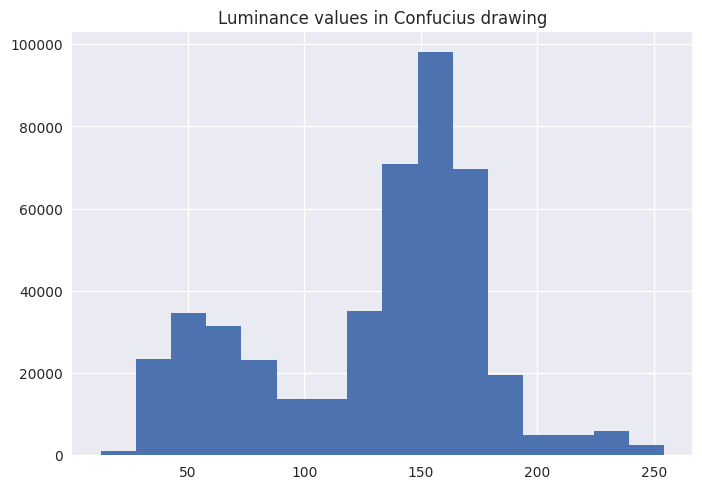

In [24]:
with plt.style.context('seaborn-v0_8'):
    plt.hist(data.mean(axis=2).reshape(800*566), bins=16)
    plt.title("Luminance values in Confucius drawing");

Let's create a histogram of the total brightness of points in the image as one way to characterize the image.

The code is compact.  We first take the mean of the channels using axis 2 of the array.  This effectively is the grayscale version of the image.  We use `matplotlib` to draw a histogram, and wrap it in a context manager to choose a visual style for the plot.

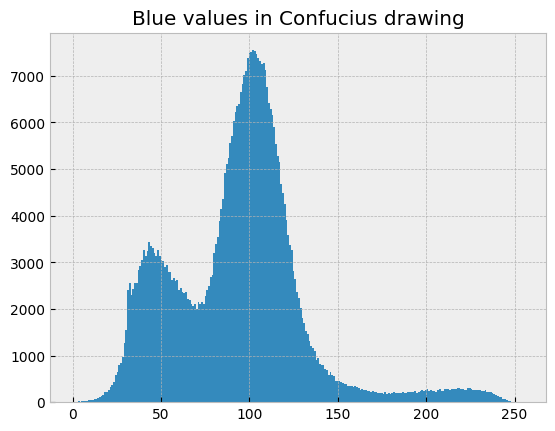

In [25]:
with plt.style.context('bmh'):  # A different visual style
    plt.hist(data[:, :, 2].reshape(800*566), bins=256)
    plt.title("Blue values in Confucius drawing")

Here we've instead selected only the blue values from the image rather the examine the grayscale version.  We also use binning into the count of all values. Depending on our purpose, examining that difference could be informative to an analysis of an image. More likely, code similar to this might compare a large family of image files.

The general point of this illustration is simply that it is straightforward to treat image files themselves as data that can be analyzed.

## Metadata

In [26]:
from PIL.ExifTags import TAGS
TAGS.update({0xc6d2: "PanasonicTitle", 0xc6d3: "PanasonicTitle2"})

def get_exif(img):
    txtdata, bindata = dict(), dict()
    for tag_id in (exifdata := img.getexif()):
        # Lookup tag name from tag_id if available
        tag = TAGS.get(tag_id, tag_id)
        data = exifdata.get(tag_id)
        if isinstance(data, bytes):
            bindata[tag] = data
        else:
            txtdata[tag] = data
    return txtdata, bindata

Photographic images may contain metadata embedded inside them.  Specifically, the *Exchangeable Image File Format* (Exif) specifies how such metadata can be embedded in JPEG, TIFF, and the WAV audio format. Digital cameras typically add this information to the images they create, often including details such as timestamp and latitude/longitude location.

Some of the data fields within an Exif mapping are textual, numeric, or tuples; others are binary data.  Moreover, the *keys* in the mapping are from ID numbers that are not meaningful to humans directly; this mapping is a published standard, but some equipment makers may introduce their own IDs as well.  The binary fields contain a variety of types of data, encoded in various ways.  For example, some cameras may attach small preview images as Exif metadata; but simpler fields are also encoded.

The `get_exif()` function return two dictionaries using the Pillow library, one for the textual data, the other for the binary data.  Tag IDs are expanded to human readable names, where available.

In [27]:
get_exif(仲尼)  # Zhòngní, i.e. Confucius

({}, {})

We see that the Confucius image we analyzed briefly does not have any such metadata.  Let's look instead at a photograph taken of me next to a Lenin statue in Minsk.  That is, I know it was taken by a digital camera that I owned at the time.

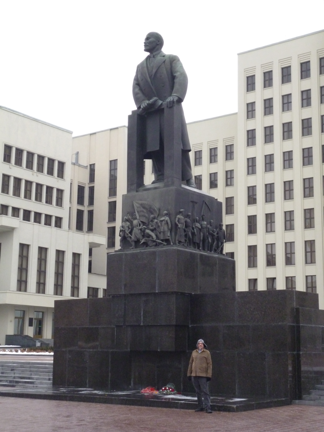

In [28]:
dqm = Image.open('img/DQM-with-Lenin-Minsk.jpg')
ImageOps.scale(dqm, 0.1)

This image, taken with a digital camera, indeed has Exif metadata.  These generally concern photographic settings, which are perhaps valuable to analyze in comparing images.  This example also has a timestamp, although not in this case a latitude/longitude position; the camera used did not have a GPS sensor.  Location data, where available, can obviously be valuable for many purposes.

In [29]:
txtdata, bindata = get_exif(dqm)

In [30]:
# The actual image somehow had exif data reduced, let's fake it for course
txtdata = {
 'DateTime': '2015:02:01 13:01:53',
 'CompressedBitsPerPixel': 4.0,
 'MaxApertureValue': 4.2734375,
 'Flash': 16,
 'FocalLength': 10.0,
 'ColorSpace': 1,
 'ExifImageWidth': 3240,
 'ExifImageHeight': 4320,
 'FocalLengthIn35mmFilm': 56,
 'Make': 'Panasonic',
 'Model': 'DMC-FH4',
 'ExposureTime': 0.00625,
 'XResolution': 180.0,
 'YResolution': 180.0,
 'ISOSpeedRatings': 500,
 'ResolutionUnit': 2,
 'ExifOffset': 634,
}

In [31]:
print("Bindata:", " ".join(bindata))
for k, v in txtdata.items():
    print(f"{k:<26}{v}")

Bindata: PrintImageMatching PanasonicTitle PanasonicTitle2
DateTime                  2015:02:01 13:01:53
CompressedBitsPerPixel    4.0
MaxApertureValue          4.2734375
Flash                     16
FocalLength               10.0
ColorSpace                1
ExifImageWidth            3240
ExifImageHeight           4320
FocalLengthIn35mmFilm     56
Make                      Panasonic
Model                     DMC-FH4
ExposureTime              0.00625
XResolution               180.0
YResolution               180.0
ISOSpeedRatings           500
ResolutionUnit            2
ExifOffset                634


These various values we can extract from this single image are not necessarily significant in themselves. However, it is easy to encounter tasks where a catalog of many images needs to be analyzed, categorized, compared, and so on.  We can programmatically pull the exif data from each image—in other words, a whole bunch of numbers with field names—and treat that as standard tabular data to perform statistics, input into machine learning models, and so on.

## Denouement

_They invaded the hexagons, showed credentials which were not always false, 
leafed through a volume with displeasure and condemned whole shelves: their 
hygienic, ascetic furor caused the senseless perdition of millions of books._

Jorge Luis Borges (The Library of Babel)

This lesson contemplated data sources that you may not think of as *data* per se.  

Within web pages and PDF document, the intention is usually to present human readable content that only contains analyzable data as a secondary concern.  In the ideal situation, whoever produced those less structured documents will also provide structured versions of the same data; however, that ideal situation is only occasionally realized.  A few nicely written Free Software libaries let us do a reasonable job of extracting meaningful data from these source, albeit always in a way that is somewhat specific to the particular document, or at least to the family or revisions, of a particular document.

Images are a very common interest in machine learning.  Drawing various conclusions about or characterizations of the content portrayed in images is a key application of deep neural networks, for example.  While those actual machine learning techniques are outside the scope of this course, this lesson introduced you to the basic APIs for acquiring an array/tensor representation of images.